# Product Name Entity Recognition (NER) Model

### Background
We need to develop a Named Entity Recognition (NER) model that can automatically extract key information from product names. This will help streamline our product search functionality.

### Assignment Objective
Develop a non-LLM based Named Entity Recognition (NER) model to extract structured information from product names.


### Required Entity Labels

The model should identify and extract the following entities from product names:

1. BRAND
2. GENDER
3. FEATURES/SPECIFICATIONS
4. COLOR
5. QUANTITY
6. DIMENSIONS


In [1]:
!python --version

Python 3.10.12


#### Importing Libraries


In [2]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm
from spacy.util import minibatch, filter_spans, compounding
from spacy.training import Example
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from collections import defaultdict
from collections import Counter

#### Loading Data

In [3]:
product_ner_data = pd.read_excel('/content/Product Name NER Assignment.xlsx')
print("Shape of dataframe:", product_ner_data.shape)
product_ner_data.head(3)

Shape of dataframe: (299, 2)


,title,extracted_attributes
0,kurt adler j3767 wooden nativity advent calend...,"{""brand"": [""kurt adler""], ""features_specificat..."
1,royal sovereign arp-1000e 10000-btu electronic...,"{""brand"": [""royal sovereign""], ""features_speci..."
2,delonghi pac-360 portable air conditioner,"{""brand"": [""delonghi""], ""features_specificatio..."


In [4]:
print(product_ner_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   title                 299 non-null    object
 1   extracted_attributes  299 non-null    object
dtypes: object(2)
memory usage: 4.8+ KB
None


### Data Preprocessing
The data consists of 299 entries, with 2 columns,  **Title** of the product, and the **Extracted Attributes** JSON which have information on **BRAND, FEATURE_SPECIFICATIONS, COLOR, QUANTITY, GENDER, DIMENSIONS**. As we need entities for NER, so let's create a new column with entities for the respective titles.

##### Creating Entities for NER model

In [5]:
def create_entities(row):

    title = row['title'].lower()
    entities = []
    attributes = row['extracted_attributes']

    attributes = json.loads(attributes)
    for entity_type, values in attributes.items():
        values = [str(v).strip().lower() for v in values]
        for value in values:
            if value:
                start_idx = title.find(value)
                end_idx = start_idx + len(value)
                entities.append((start_idx, end_idx, entity_type))

    return entities

In [6]:
product_ner_data['ner_entities'] = product_ner_data.apply(create_entities, axis=1)
product_ner_data.sample(3)

,title,extracted_attributes,ner_entities
67,"c&amp;w petite whole beans, 14 ounce frozen","{""brand"": [""c&w""], ""quantity"": [""14 ounce""]}","[(-1, 2, brand), (28, 36, quantity)]"
26,coby cx-cd375 micro stereo system with top-loa...,"{""brand"": [""coby""], ""features_specifications"":...","[(0, 4, brand), (5, 13, features_specification..."
266,mabef sketch box easel mbm-22,"{""brand"": [""mabef""], ""features_specifications""...","[(0, 5, brand), (23, 29, features_specificatio..."


##### Taking a look at the entities created

In [7]:
for idx, row in product_ner_data.head(1).iterrows():
    print("\nTitle:", row['title'])
    print("Entities found:")
    for start, end, label in row['ner_entities']:
        entity_text = row['title'][start:end]
        print(f"  {label}: '{entity_text}' (positions {start}:{end})")


Title: kurt adler j3767 wooden nativity advent calendar with 24 magnetic piece
Entities found:
  brand: 'kurt adler' (positions 0:10)
  features_specifications: 'j3767' (positions 11:16)
  features_specifications: 'wooden' (positions 17:23)
  features_specifications: 'nativity advent calendar' (positions 24:48)
  features_specifications: '24 magnetic piece' (positions 54:71)


Lets check the frequency of all the attributes

In [8]:
entity_counts = defaultdict(int)
sum_of_entities = 0
for _, row in product_ner_data.iterrows():
    unique_entities = set(entity[2] for entity in row['ner_entities'])
    for entity_type in unique_entities:
        entity_counts[entity_type] += 1
        sum_of_entities += 1
print(entity_counts)

# taking rare entites, which are present less than 10% of the total entities
rare_entities = [entity for entity, count in entity_counts.items() if count <= (sum_of_entities * 0.1)]
common_entities = [entity for entity, count in entity_counts.items() if count > (sum_of_entities * 0.1)]

print(f"Identified {len(rare_entities)} rare entities: {rare_entities}")
print(f"Identified {len(common_entities)} common entities.")

defaultdict(<class 'int'>, {'features_specifications': 283, 'brand': 267, 'quantity': 157, 'color': 92, 'dimensions': 8, 'gender': 10})
Identified 2 rare entities: ['dimensions', 'gender']
Identified 4 common entities.


As we are getting unbalanced data, we will have to distribute the data in train, test and val, such that the less frequency attributes are not missed

##### Upsampling and Creating a train-test split

In [9]:
from sklearn.utils import resample

rare_df = product_ner_data[product_ner_data['ner_entities'].apply(lambda x: any(e[2] in rare_entities for e in x))]
common_df = product_ner_data[~product_ner_data['ner_entities'].apply(lambda x: any(e[2] in rare_entities for e in x))]

rare_df_oversampled = resample(rare_df, replace=True, n_samples=100, random_state=42)

product_ner_data = pd.concat([common_df, rare_df_oversampled])

In [10]:
product_ner_data.shape

(381, 3)

In [11]:
train_product_ner_data, test_temp = train_test_split(product_ner_data, test_size=0.2, random_state=42)
test_product_ner_data, val_product_ner_data = train_test_split(test_temp, test_size=0.5, random_state=42)

print(f"Train size: {len(train_product_ner_data)}, Val size: {len(val_product_ner_data)}, Test size: {len(test_product_ner_data)}")

Train size: 304, Val size: 39, Test size: 38


In [12]:
nlp_ner = spacy.blank("en")

##### Preparing the data for training

In [13]:
def preprocess_text(text):
    text = ' '.join(text.lower().strip().split())
    return text

def prepare_training_data(df, nlp):
    db = DocBin()

    for _, row in tqdm(df.iterrows(), desc="Preparing training data"):
        text = preprocess_text(row['title'])
        entities = row['ner_entities']

        doc = nlp.make_doc(text)
        ents = []

        for start, end, label in entities:
            try:
                span = doc.char_span(start, end, label=label, alignment_mode="contract")
                if span is not None:
                    ents.append(span)
            except ValueError as e:
                print(f"Error creating span for text: {text}, positions {start}:{end}")
                continue

        filtered_ents = filter_spans(ents)
        doc.ents = filtered_ents
        db.add(doc)

    return db

In [14]:
train_docbin = prepare_training_data(train_product_ner_data, nlp_ner)
val_docbin = prepare_training_data(val_product_ner_data, nlp_ner)
test_docbin = prepare_training_data(test_product_ner_data, nlp_ner)

Preparing training data: 304it [00:00, 1502.81it/s]
Preparing training data: 39it [00:00, 1721.42it/s]
Preparing training data: 38it [00:00, 1615.89it/s]


### Model Training

In [15]:
def evaluate_model(nlp, data):
    losses = {}
    examples = []
    for doc in data.get_docs(nlp.vocab):
        example = Example.from_dict(
            nlp.make_doc(doc.text),
            {"entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]}
        )
        examples.append(example)
    nlp.update(examples, drop=0.0, losses=losses)
    return losses["ner"]

def train_spacy(nlp_ner, train_data, val_data, max_patience=5):

    if "ner" not in nlp_ner.pipe_names:
        ner = nlp_ner.add_pipe("ner", last=True)

    ner = nlp_ner.get_pipe("ner")

    for doc in train_data.get_docs(nlp_ner.vocab):
        for ent in doc.ents:
            ner.add_label(ent.label_)

    optimizer = nlp_ner.begin_training()
    best_loss = float('inf')
    best_model = None
    patience = 0
    losses = []

    while patience < max_patience:
        random.shuffle(list(train_data.get_docs(nlp_ner.vocab)))
        batches = minibatch(train_data.get_docs(nlp_ner.vocab), size=compounding(4.0, 32.0, 1.001))

        for batch in tqdm(batches, desc=f"Training (patience: {patience})"):
            examples = []
            for doc in batch:
                example = Example.from_dict(
                    nlp_ner.make_doc(doc.text),
                    {"entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]}
                )
                examples.append(example)
            nlp_ner.update(examples, drop=0.5)

        val_loss = evaluate_model(nlp_ner, val_data)
        losses.append(val_loss)
        print(f"Validation loss: {val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = nlp_ner.to_bytes()
            patience = 0
        else:
            patience += 1

    # loading best model
    if best_model is not None:
        nlp_ner.from_bytes(best_model)

    return nlp_ner, losses


In [16]:
nlp_product_ner_model, losses = train_spacy(nlp_ner, train_docbin, val_docbin)

Training (patience: 0): 76it [00:02, 30.11it/s]


Validation loss: 221.9750


Training (patience: 0): 76it [00:02, 31.49it/s]


Validation loss: 196.0620


Training (patience: 0): 76it [00:02, 27.97it/s]


Validation loss: 190.2436


Training (patience: 0): 76it [00:03, 23.33it/s]


Validation loss: 156.2358


Training (patience: 0): 76it [00:02, 31.83it/s]


Validation loss: 165.5400


Training (patience: 1): 76it [00:02, 32.23it/s]


Validation loss: 115.5597


Training (patience: 0): 76it [00:02, 31.70it/s]


Validation loss: 98.0902


Training (patience: 0): 76it [00:02, 26.72it/s]


Validation loss: 66.3042


Training (patience: 0): 76it [00:03, 23.59it/s]


Validation loss: 78.3334


Training (patience: 1): 76it [00:02, 31.71it/s]


Validation loss: 50.8028


Training (patience: 0): 76it [00:02, 32.38it/s]


Validation loss: 52.5763


Training (patience: 1): 76it [00:02, 32.25it/s]


Validation loss: 44.0275


Training (patience: 0): 76it [00:02, 27.30it/s]


Validation loss: 70.7320


Training (patience: 1): 76it [00:03, 24.47it/s]


Validation loss: 47.5436


Training (patience: 2): 76it [00:02, 32.12it/s]


Validation loss: 52.8749


Training (patience: 3): 76it [00:02, 31.37it/s]


Validation loss: 32.2701


Training (patience: 0): 76it [00:02, 31.78it/s]


Validation loss: 42.7844


Training (patience: 1): 76it [00:03, 20.92it/s]


Validation loss: 33.1977


Training (patience: 2): 76it [00:02, 27.37it/s]


Validation loss: 30.6469


Training (patience: 0): 76it [00:02, 28.57it/s]


Validation loss: 24.3700


Training (patience: 0): 76it [00:06, 10.96it/s]


Validation loss: 25.6086


Training (patience: 1): 76it [00:11,  6.74it/s]


Validation loss: 16.8677


Training (patience: 0): 76it [00:05, 14.04it/s]


Validation loss: 9.8672


Training (patience: 0): 76it [00:02, 31.26it/s]


Validation loss: 10.1594


Training (patience: 1): 76it [00:02, 32.09it/s]


Validation loss: 6.1096


Training (patience: 0): 76it [00:02, 31.90it/s]


Validation loss: 5.5691


Training (patience: 0): 76it [00:02, 26.57it/s]


Validation loss: 19.3593


Training (patience: 1): 76it [00:02, 25.56it/s]


Validation loss: 6.6833


Training (patience: 2): 76it [00:02, 31.65it/s]


Validation loss: 6.3029


Training (patience: 3): 76it [00:02, 31.84it/s]


Validation loss: 5.1166


Training (patience: 0): 76it [00:02, 32.29it/s]


Validation loss: 2.7497


Training (patience: 0): 76it [00:02, 25.44it/s]


Validation loss: 3.3370


Training (patience: 1): 76it [00:03, 24.98it/s]


Validation loss: 4.9455


Training (patience: 2): 76it [00:02, 32.15it/s]


Validation loss: 4.5008


Training (patience: 3): 76it [00:02, 31.66it/s]


Validation loss: 6.5308


Training (patience: 4): 76it [00:02, 31.86it/s]


Validation loss: 7.2708


#### Plotting the loss

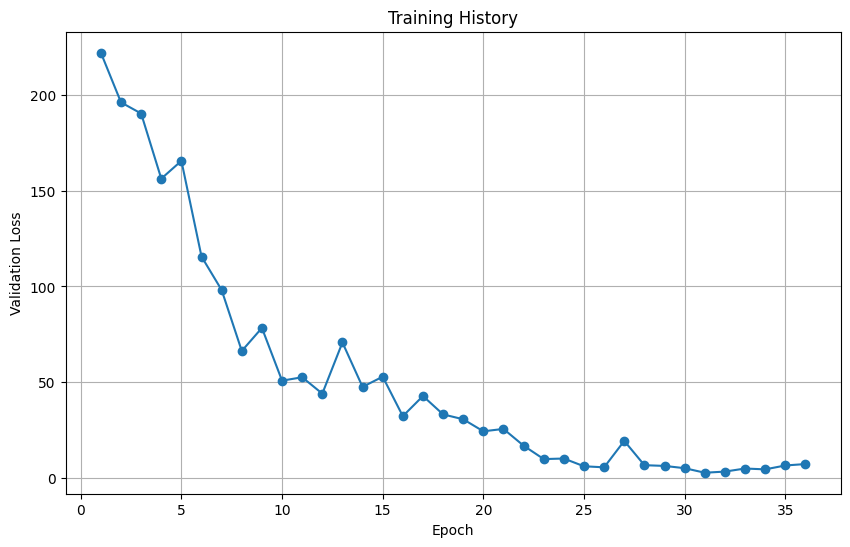

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Training History")
plt.grid(True)
plt.show()

### Testing model

In [18]:
print("\nTesting the model:")
for _, row in test_product_ner_data.iterrows():
    doc = nlp_product_ner_model(preprocess_text(row['title']))
    print(f"\nText: {row['title']}")
    print("Predicted entities:")
    for ent in doc.ents:
        print(f"  {ent.label_}: '{ent.text}' ({ent.start_char}:{ent.end_char})")

    print("Original Entities:")
    for start, end, label in row['ner_entities']:
        entity_text = row['title'][start:end]
        print(f"  {label}: '{entity_text}' (positions {start}:{end})")


Testing the model:

Text: park b. smith nassau stripe 40-by-24-inch rug, mesquite
Predicted entities:
  brand: 'park b. smith' (0:13)
  quantity: '40-by-24-inch' (28:41)
  features_specifications: 'rug' (42:45)
  color: 'mesquite' (47:55)
Original Entities:
  brand: 'park b. smith' (positions 0:13)
  color: 'mesquite' (positions 47:55)
  quantity: '40-by-24-inch' (positions 28:41)
  features_specifications: 'nassau stripe' (positions 14:27)
  features_specifications: 'rug' (positions 42:45)

Text: sandra darren women's paisley-print sheath dress
Predicted entities:
  brand: 'sandra darren' (0:13)
  gender: 'women's' (14:21)
  features_specifications: 'paisley-print' (22:35)
  features_specifications: 'sheath dress' (36:48)
Original Entities:
  brand: 'sandra darren' (positions 0:13)
  gender: 'women's' (positions 14:21)
  features_specifications: 'paisley-print' (positions 22:35)
  features_specifications: 'sheath dress' (positions 36:48)

Text: rodelle organic pure vanilla extract, 4

## Some good predictions


In [ ]:
# Text: sunjel fume-free firespace gel fuel canister, pure gel, 24-pack
# Predicted entities:
#   brand: 'sunjel' (0:6)
#   features_specifications: 'fume-free' (7:16)
#   features_specifications: 'firespace gel fuel canister' (17:44)
#   features_specifications: 'pure gel' (46:54)
#   quantity: '24-pack' (56:63)
# Original Entities:
#   brand: 'sunjel' (positions 0:6)
#   quantity: '24-pack' (positions 56:63)
#   features_specifications: 'fume-free' (positions 7:16)
#   features_specifications: 'firespace gel fuel canister' (positions 17:44)
#   features_specifications: 'pure gel' (positions 46:54)


# Text: cascadian farm organic sweet corn, 16oz bag frozen, organically farmed frozen vegetables, non-gmo
# Predicted entities:
#   brand: 'cascadian farm' (0:14)
#   features_specifications: 'organic' (15:22)
#   features_specifications: 'sweet corn' (23:33)
#   quantity: '16oz bag' (35:43)
#   features_specifications: 'frozen' (44:50)
#   features_specifications: 'organically farmed' (52:70)
#   features_specifications: 'frozen vegetables' (71:88)
#   features_specifications: 'non-gmo' (90:97)
# Original Entities:
#   brand: 'cascadian farm' (positions 0:14)
#   quantity: '16oz bag' (positions 35:43)
#   features_specifications: 'organic' (positions 15:22)
#   features_specifications: 'sweet corn' (positions 23:33)
#   features_specifications: 'frozen' (positions 44:50)
#   features_specifications: 'organically farmed' (positions 52:70)
#   features_specifications: 'frozen vegetables' (positions 71:88)
#   features_specifications: 'non-gmo' (positions 90:97)

# ext: american metalcraft bnbb13202 rectangular birdnest wire basket, black
# Predicted entities:
#   brand: 'american metalcraft' (0:19)
#   features_specifications: 'rectangular' (30:41)
#   features_specifications: 'birdnest' (42:50)
#   features_specifications: 'wire basket' (51:62)
#   color: 'black' (64:69)
# Original Entities:
#   brand: 'american metalcraft' (positions 0:19)
#   color: 'black' (positions 64:69)
#   features_specifications: 'bnbb13202' (positions 20:29)
#   features_specifications: 'rectangular' (positions 30:41)
#   features_specifications: 'birdnest' (positions 42:50)
#   features_specifications: 'wire basket' (positions 51:62)


### Needs improvement

In [ ]:
# Text: disney baby girls' frozen swimsuit
# Predicted entities:
#   brand: 'disney' (0:6)
#   features_specifications: 'baby' (7:11)
#   quantity: 'girls'' (12:18)
#   features_specifications: 'frozen' (19:25)
#   features_specifications: 'swimsuit' (26:34)
# Original Entities:
#   brand: 'disney' (positions 0:6)
#   gender: 'girls' (positions 12:17)
#   features_specifications: 'baby' (positions 7:11)
#   features_specifications: 'frozen' (positions 19:25)
#   features_specifications: 'swimsuit' (positions 26:34)


# Text: metaltex usa inc. econo dryer, white, 32-inch
# Predicted entities:
#   brand: 'metaltex usa' (0:12)
#   features_specifications: 'inc. econo' (13:23)
#   color: 'white' (31:36)
#   quantity: '32-inch' (38:45)
# Original Entities:
#   brand: 'metaltex usa' (positions 0:12)
#   color: 'white' (positions 31:36)
#   features_specifications: 'econo dryer' (positions 18:29)
#   dimensions: '32-inch' (positions 38:45)

The model is getting confused between the quantities and dimensions attribute

##### Evaluating the model

Lets take the entity text and labels from the original entities and predicted entities. And calculate metrics for each entity(lable).

In [21]:
def evaluate_ner_from_df(test_df, nlp_product_ner_model):

    entity_types = set()
    all_true = defaultdict(list)
    all_pred = defaultdict(list)

    for _, row in test_df.iterrows():

        doc = nlp_product_ner_model(preprocess_text(row['title']))
        predicted_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
        ground_truth_entities = row['ner_entities']

        for start, end, label in ground_truth_entities:
            entity_text = row['title'][start:end]
            all_true[label].append(entity_text)
            entity_types.add(label)

        for start, end, label in predicted_entities:
            entity_text = row['title'][start:end]
            all_pred[label].append(entity_text)
            entity_types.add(label)

    metrics = {}
    overall_true = []
    overall_pred = []

    for entity_type in entity_types:
        true_labels = all_true[entity_type]
        pred_labels = all_pred[entity_type]

        overall_true.extend(true_labels)
        overall_pred.extend(pred_labels)

        y_true = [1 if label in true_labels else 0 for label in true_labels + pred_labels]
        y_pred = [1 if label in pred_labels else 0 for label in true_labels + pred_labels]

        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            average="binary",
            zero_division=0
        )

        metrics[entity_type] = {
            "precision": precision,
            "recall": recall,
            "f1": f1
        }

    y_true_overall = [1 if label in overall_true else 0 for label in overall_true + overall_pred]
    y_pred_overall = [1 if label in overall_pred else 0 for label in overall_true + overall_pred]

    overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(
        y_true=y_true_overall,
        y_pred=y_pred_overall,
        average="binary",
        zero_division=0
    )

    metrics["overall"] = {
        "precision": overall_precision,
        "recall": overall_recall,
        "f1": overall_f1
    }

    return metrics

In [22]:
metrics = evaluate_ner_from_df(test_product_ner_data, nlp_product_ner_model)
metrics # new

{'brand': {'precision': 0.7936507936507936,
  'recall': 0.8333333333333334,
  'f1': 0.8130081300813008},
 'quantity': {'precision': 0.82,
  'recall': 0.8723404255319149,
  'f1': 0.845360824742268},
 'color': {'precision': 0.9117647058823529,
  'recall': 0.96875,
  'f1': 0.9393939393939394},
 'gender': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
 'dimensions': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
 'features_specifications': {'precision': 0.6299212598425197,
  'recall': 0.6349206349206349,
  'f1': 0.6324110671936759},
 'overall': {'precision': 0.7859531772575251,
  'recall': 0.8075601374570447,
  'f1': 0.7966101694915254}}

In [ ]:
metrics = evaluate_ner_from_df(test_product_ner_data, nlp_product_ner_model)
metrics # wo upsampling

{'color': {'precision': 0.9047619047619048,
  'recall': 0.8260869565217391,
  'f1': 0.8636363636363636},
 'gender': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0},
 'quantity': {'precision': 0.7,
  'recall': 0.9032258064516129,
  'f1': 0.7887323943661971},
 'features_specifications': {'precision': 0.7,
  'recall': 0.5986842105263158,
  'f1': 0.6453900709219859},
 'brand': {'precision': 0.7777777777777778,
  'recall': 0.7636363636363637,
  'f1': 0.7706422018348624},
 'dimensions': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0},
 'overall': {'precision': 0.7843137254901961,
  'recall': 0.7220216606498195,
  'f1': 0.7518796992481203}}

In [24]:
# metric-> wrongly marked

### Results:
The model is performing good overall


#### Saving model for Production

In [23]:
import shutil

folder_path = '/content/product_ner_model'
nlp_ner.to_disk(folder_path)

# Zip the folder for downloading
zip_file_path = '/content/Product_Name_NER_Model.zip'
shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', folder_path)

'/content/Product_Name_NER_Model.zip'